## HMMs and Viterbi algorithm for POS tagging

<b>Problem Statement:</b>

We have learnt to build our own HMM-based POS tagger and implement the Viterbi algorithm using the Penn Treebank training corpus. The vanilla Viterbi algorithm we had written had resulted in ~87% accuracy. The approx. 13% loss of accuracy was majorly due to the fact that when the algorithm encountered an unknown word (i.e. not present in the training set, such as 'Twitter'), it assigned an incorrect tag arbitrarily. This is because, for unknown words, the emission probabilities for all candidate tags are 0, so the algorithm arbitrarily chooses (the first) tag.

In this assignment, we need to modify the Viterbi algorithm to solve the problem of unknown words using at least two techniques. Though there could be multiple ways to solve this problem, you may use the following hints:

- Which tag class do you think most unknown words belong to? Can you identify rules (e.g. based on morphological cues) that can be used to tag unknown words? 

- We may define separate python functions to exploit these rules so that they work in tandem with the original Viterbi algorithm.

- Why does the Viterbi algorithm choose a random tag on encountering an unknown word? Can you modify the Viterbi algorithm so that it considers only one of the transition or emission probabilities for unknown words?

We need to accomplish the following in this assignment:

- Write the vanilla Viterbi algorithm for assigning POS tags (i.e. without dealing with unknown words) 
- Solve the problem of unknown words using at least two techniques. These techniques can use any of the approaches     discussed in the class - lexicon, rule-based, probabilistic etc. Note that to implement these techniques, we can either write separate functions and call them from the main Viterbi algorithm, or modify the Viterbi algorithm, or both.
- Compare the tagging accuracy after making these modifications with the vanilla Viterbi algorithm.
- List down at least three cases from the sample test file (i.e. unknown word-tag pairs) which were incorrectly tagged by the original Viterbi POS tagger and got corrected after your modifications.


### Data Preparation

In [1]:
#Importing libraries
import nltk , re ,pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
random.seed(1234)

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))
print(nltk_data[:5])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [57]:
##splitting the data into the requested ratio for training and validation
random.seed(1234)
train_set , val_set = train_test_split(nltk_data,test_size = 0.05)

In [4]:
print("-" * 100)
print("Training Set Length - " , len(train_set))
print("Validation Set Length - " , len(val_set))
print("-" * 100)

----------------------------------------------------------------------------------------------------
Training Set Length -  3718
Validation Set Length -  196
----------------------------------------------------------------------------------------------------


In [5]:
##Lets have a look at samples from Training data set created
print(train_set[:10])

[[('Odyssey', 'NOUN'), ('Partners', 'NOUN'), ('Limited', 'NOUN'), ('Partnership', 'NOUN'), (',', '.'), ('an', 'DET'), ('investment', 'NOUN'), ('firm', 'NOUN'), (',', '.'), ('completed', 'VERB'), ('the', 'DET'), ('purchase', 'NOUN'), ('of', 'ADP'), ('May', 'NOUN'), ('Department', 'NOUN'), ('Stores', 'NOUN'), ('Co.', 'NOUN'), ("'s", 'PRT'), ('Caldor', 'NOUN'), ('discount', 'NOUN'), ('chain', 'NOUN'), ('for', 'ADP'), ('$', '.'), ('500', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('plus', 'CONJ'), ('the', 'DET'), ('assumption', 'NOUN'), ('of', 'ADP'), ('$', '.'), ('52', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('in', 'ADP'), ('debt', 'NOUN'), ('.', '.')], [('South', 'NOUN'), ('Carolina', 'NOUN'), ("'s", 'PRT'), ('reforms', 'NOUN'), ('were', 'VERB'), ('designed', 'VERB'), ('*-1', 'X'), ('for', 'ADP'), ('schools', 'NOUN'), ('like', 'ADP'), ('Greenville', 'NOUN'), ('High', 'NOUN'), ('School', 'NOUN'), ('.', '.')], [('*-1', 'X'), ('Concerned', 'VERB'), ('about', 'ADP'), ('shrinking', 'VERB'), 

In [6]:
# Getting list of train tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]

print("-" * 100)
print("Train tagged words Length - " , len(train_tagged_words))
print("-" * 100)

----------------------------------------------------------------------------------------------------
Train tagged words Length -  95592
----------------------------------------------------------------------------------------------------


In [7]:
##lets get the tags and tokens from tagged trained words
train_data_tokens = [pair[0] for pair in train_tagged_words]
train_data_tags = [pair[1] for pair in train_tagged_words]

print("-" * 100)
print("Train data tokens length - " , len(train_data_tokens))
print("Train data tags distinct count - " , len(set(train_data_tags)))
print("\n")
print("Distinct Tags as per the universal tagset are as below -")
print(list(set(train_data_tags)))
print("-" * 100)

----------------------------------------------------------------------------------------------------
Train data tokens length -  95592
Train data tags distinct count -  12


Distinct Tags as per the universal tagset are as below -
['VERB', 'CONJ', 'ADJ', 'PRON', 'ADV', 'DET', 'NOUN', '.', 'ADP', 'PRT', 'X', 'NUM']
----------------------------------------------------------------------------------------------------


In [8]:
##building the set of training vocabulary and POS tags

train_data_vocab_set = set(train_data_tokens)
train_data_tag_set   = set(train_data_tags)

print("-" * 100)
print("Train data vocabulary length - " , len(train_data_vocab_set))
print("Train data tag length - " ,len(train_data_tag_set))
print("-" * 100)

----------------------------------------------------------------------------------------------------
Train data vocabulary length -  12096
Train data tag length -  12
----------------------------------------------------------------------------------------------------


<b>Before proceeding for the Viterbi Heuristic we write methods to calculate:

1- Transition Probabilities 2- Emission Probabilities

In [9]:
# computing P(w/t) and storing in T x V matrix
t = len(train_data_tag_set)
v = len(train_data_vocab_set)
w_given_t = np.zeros((t, v))

In [10]:
# Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    taglist = [pair for pair in train_bag if pair[1] == tag]
    tag_count = len(taglist)
    w_given_tag_list = [pair[0] for pair in taglist if pair[0]== word]
    count_w_given_tag = len(w_given_tag_list)
    return(count_w_given_tag, tag_count)

In [11]:
# Transition Probability
def t2_given_t1(t2,t1,train_bag=train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    t1_tags = [tag for tag in tags if tag==t1]
    count_of_t1 = len(t1_tags)
    t2_given_t1 = [tags[index+1] for index in range(len(tags)-1) if tags[index] == t1 and tags[index+1] == t2]
    count_t2_given_t1 = len(t2_given_t1)
    return(count_t2_given_t1,count_of_t1)


<b>Transition Matrix<b/>

In [12]:
# creating t x t transition matrix of tags

tags_matrix = np.zeros((len(train_data_tag_set), len(train_data_tag_set)), dtype='float32')

for i, t1 in enumerate(list(train_data_tag_set)):
    for j, t2 in enumerate(list(train_data_tag_set)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

tags_matrix        

array([[1.70073837e-01, 5.36338892e-03, 6.54488951e-02, 3.50563526e-02,
        8.11504051e-02, 1.33229688e-01, 1.10921107e-01, 3.51340845e-02,
        9.13330764e-02, 3.13253030e-02, 2.17722505e-01, 2.32413523e-02],
       [1.57282457e-01, 4.65332705e-04, 1.18659839e-01, 5.90972528e-02,
        5.44439256e-02, 1.17729180e-01, 3.49930197e-01, 3.53652872e-02,
        5.30479290e-02, 5.11865970e-03, 6.51465775e-03, 4.23452780e-02],
       [1.20105296e-02, 1.66173074e-02, 6.76209256e-02, 6.58111239e-04,
        4.93583409e-03, 4.93583409e-03, 6.97762430e-01, 6.64692298e-02,
        7.60118440e-02, 1.11878905e-02, 2.08950303e-02, 2.08950303e-02],
       [4.86980170e-01, 5.05246781e-03, 7.22891539e-02, 8.16167891e-03,
        3.34240198e-02, 9.32763331e-03, 2.06762537e-01, 4.08083946e-02,
        2.37077344e-02, 1.32141467e-02, 9.24990252e-02, 7.77302776e-03],
       [3.39973450e-01, 6.97211176e-03, 1.29814073e-01, 1.56042501e-02,
        7.93492720e-02, 7.00531229e-02, 3.25365216e-02, 1.38

In [13]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(train_data_tag_set), index=list(train_data_tag_set))

In [14]:
tags_df

,VERB,CONJ,ADJ,PRON,ADV,DET,NOUN,.,ADP,PRT,X,NUM
VERB,0.170074,0.005363,0.065449,0.035056,0.081150,0.133230,0.110921,0.035134,0.091333,0.031325,0.217723,0.023241
CONJ,0.157282,0.000465,0.118660,0.059097,0.054444,0.117729,0.349930,0.035365,0.053048,0.005119,0.006515,0.042345
ADJ,0.012011,0.016617,0.067621,0.000658,0.004936,0.004936,0.697762,0.066469,0.076012,0.011188,0.020895,0.020895
PRON,0.486980,0.005052,0.072289,0.008162,0.033424,0.009328,0.206763,0.040808,0.023708,0.013214,0.092499,0.007773
ADV,0.339973,0.006972,0.129814,0.015604,0.079349,0.070053,0.032537,0.138446,0.118858,0.014276,0.022908,0.031209
DET,0.039296,0.000482,0.205400,0.003375,0.012536,0.005424,0.638501,0.017719,0.009161,0.000241,0.045805,0.022059
NOUN,0.146751,0.042653,0.012114,0.004597,0.017295,0.013062,0.264057,0.240632,0.176196,0.044149,0.028861,0.009633
.,0.089070,0.057739,0.044132,0.065169,0.053173,0.174559,0.221198,0.093635,0.090681,0.002506,0.026855,0.081192
ADP,0.008461,0.000857,0.105494,0.068223,0.013388,0.325586,0.321838,0.040698,0.016601,0.001285,0.035022,0.062547
PRT,0.397842,0.002288,0.085322,0.017326,0.010134,0.102648,0.247466,0.042824,0.020922,0.001961,0.013076,0.058189


<b>EXPLORATORY DATA ANALYSIS</b>

- Heatmap of tags matrix is created and analysed.

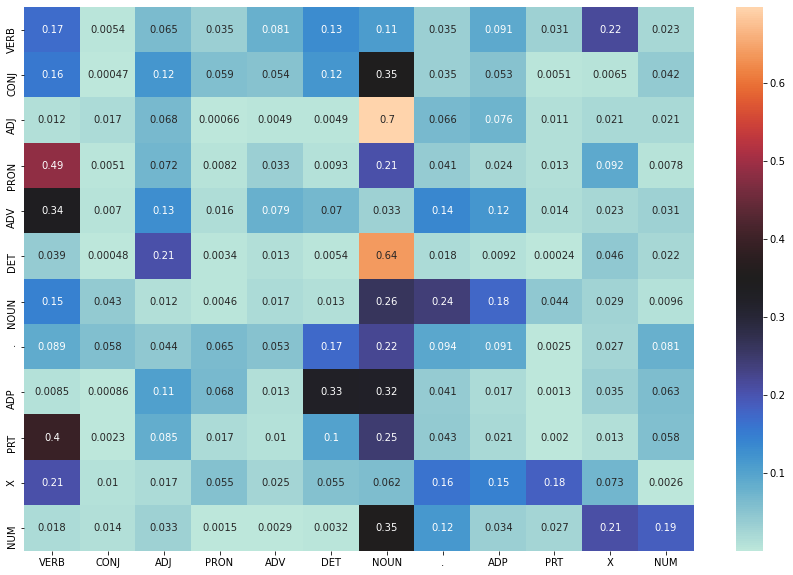

In [15]:
# heatmap of tags matrix
# T(i, j) indicates P(tag j given tag i)
plt.figure(figsize=(15, 10))
sns.heatmap(tags_df, annot = True,cmap="icefire")
plt.show()

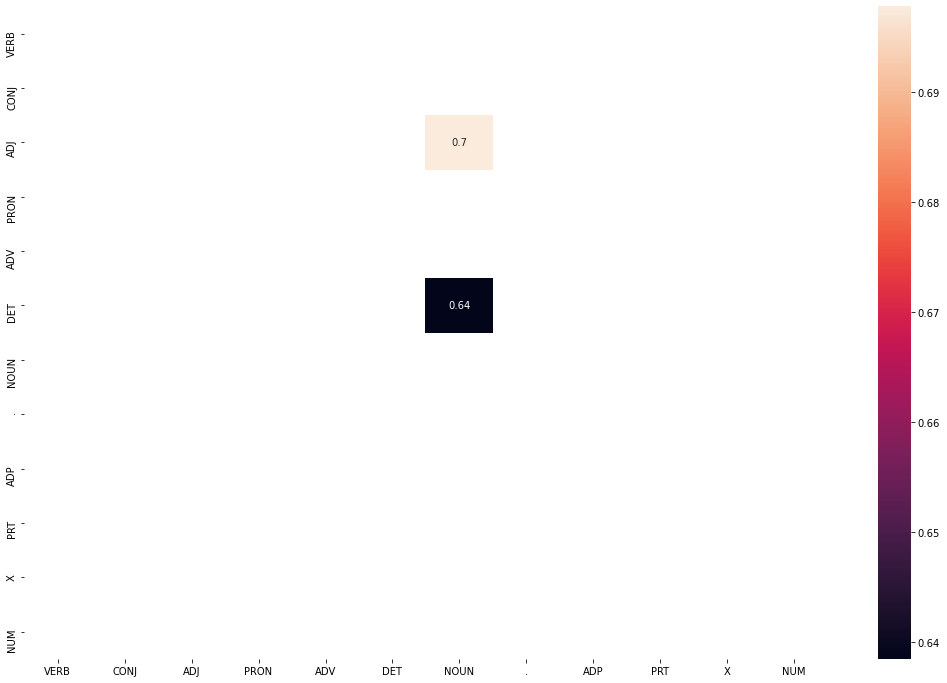

In [16]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent , annot = True)
plt.show()

### 1. Build the vanilla Viterbi based POS tagger :

In [17]:
# Viterbi
def Vanilla_Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # lets compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

### Testing Vanilla Viterbi Algorithm on validation dataset :

In [18]:
random.seed(1234)

# list of tagged words
val_run_base = [tup for sent in val_set for tup in sent]

# list of untagged words
val_tagged_words = [tup[0] for sent in val_set for tup in sent]
val_tagged_words

['``',
 'We',
 'flat',
 'ran',
 'out',
 'of',
 'financing',
 'resources',
 ',',
 "''",
 'Mr.',
 'Jerritts',
 'said',
 '*T*-1',
 '.',
 'The',
 'compromise',
 'sets',
 'the',
 'training',
 'wage',
 'at',
 '$',
 '3.35',
 '*U*',
 'an',
 'hour',
 'next',
 'April',
 ',',
 'and',
 'at',
 '$',
 '3.61',
 '*U*',
 'an',
 'hour',
 ',',
 'or',
 '85',
 '%',
 'of',
 'the',
 'minimum',
 'wage',
 ',',
 'in',
 'April',
 '1991',
 '.',
 'A',
 'reading',
 'below',
 '50',
 '%',
 'indicates',
 'that',
 'the',
 'manufacturing',
 'sector',
 'is',
 'slowing',
 'while',
 'a',
 'reading',
 'above',
 '50',
 '%',
 'suggests',
 'that',
 'the',
 'industry',
 'is',
 'expanding',
 '.',
 'The',
 'study',
 'shows',
 'that',
 'nearly',
 '40',
 '%',
 'of',
 'the',
 'homeless',
 'population',
 'is',
 'made',
 'up',
 '*-21',
 'of',
 'women',
 'and',
 'children',
 'and',
 'that',
 'only',
 '25',
 '%',
 'of',
 'the',
 'homeless',
 'exhibits',
 'some',
 'combination',
 'of',
 'drug',
 ',',
 'alcohol',
 'and',
 'mental',
 'probl

In [19]:
# tagging the validation sentences
start = time.time()
tagged_seq = Vanilla_Viterbi(val_tagged_words)
end = time.time()
difference = end-start

In [20]:
print("Time taken in seconds: ", difference)

Time taken in seconds:  1239.6033990383148


In [21]:
# accuracy
check = [i for i, j in zip(tagged_seq, val_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print("-" * 100)
print("Vanilla Viterbi Algorith Accuracy is -" , accuracy*100)
print("-" * 100)

----------------------------------------------------------------------------------------------------
Vanilla Viterbi Algorith Accuracy is - 92.11250983477576
----------------------------------------------------------------------------------------------------


In [22]:
# Incorrectly tagged words
incorrect_tagged_words = [j for i, j in enumerate(zip(tagged_seq, val_run_base)) if j[0] != j[1]]

print("Total Incorrect Tagged Words :", len(incorrect_tagged_words))
print("\n")
print("Incorrectly Tagged Words are as follow : \n" + "\n", incorrect_tagged_words)

Total Incorrect Tagged Words : 401


Incorrectly Tagged Words are as follow : 

 [(('flat', 'ADJ'), ('flat', 'ADV')), (('out', 'PRT'), ('out', 'ADP')), (('sets', 'NOUN'), ('sets', 'VERB')), (('3.61', 'VERB'), ('3.61', 'NUM')), (('manufacturing', 'NOUN'), ('manufacturing', 'VERB')), (('up', 'ADV'), ('up', 'PRT')), (('that', 'DET'), ('that', 'ADP')), (('only', 'ADJ'), ('only', 'ADV')), (('homeless', 'ADJ'), ('homeless', 'NOUN')), (('multitude', 'VERB'), ('multitude', 'NOUN')), (('food-shop', 'VERB'), ('food-shop', 'ADJ')), (('assistant', 'ADJ'), ('assistant', 'NOUN')), (('mainland', 'VERB'), ('mainland', 'NOUN')), (('Chinese', 'ADJ'), ('Chinese', 'NOUN')), (('slew', 'VERB'), ('slew', 'NOUN')), (('copycats', 'VERB'), ('copycats', 'NOUN')), (('fiber', 'VERB'), ('fiber', 'NOUN')), (('resilient', 'VERB'), ('resilient', 'ADJ')), (('once', 'ADV'), ('once', 'ADP')), (('lungs', 'VERB'), ('lungs', 'NOUN')), (('symptoms', 'VERB'), ('symptoms', 'NOUN')), (('that', 'ADP'), ('that', 'DET')), (('up', 

In [23]:
incorrect_tagged_cases = [[val_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, val_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('We', 'PRON'), (('flat', 'ADJ'), ('flat', 'ADV'))],
 [('ran', 'VERB'), (('out', 'PRT'), ('out', 'ADP'))],
 [('compromise', 'NOUN'), (('sets', 'NOUN'), ('sets', 'VERB'))],
 [('$', '.'), (('3.61', 'VERB'), ('3.61', 'NUM'))],
 [('the', 'DET'), (('manufacturing', 'NOUN'), ('manufacturing', 'VERB'))],
 [('made', 'VERB'), (('up', 'ADV'), ('up', 'PRT'))],
 [('and', 'CONJ'), (('that', 'DET'), ('that', 'ADP'))],
 [('that', 'ADP'), (('only', 'ADJ'), ('only', 'ADV'))],
 [('the', 'DET'), (('homeless', 'ADJ'), ('homeless', 'NOUN'))],
 [('a', 'DET'), (('multitude', 'VERB'), ('multitude', 'NOUN'))],
 [('Beijing', 'NOUN'), (('food-shop', 'VERB'), ('food-shop', 'ADJ'))],
 [('food-shop', 'ADJ'), (('assistant', 'ADJ'), ('assistant', 'NOUN'))],
 [('first', 'ADJ'), (('mainland', 'VERB'), ('mainland', 'NOUN'))],
 [('mainland', 'NOUN'), (('Chinese', 'ADJ'), ('Chinese', 'NOUN'))],
 [('a', 'DET'), (('slew', 'VERB'), ('slew', 'NOUN'))],
 [('of', 'ADP'), (('copycats', 'VERB'), ('copycats', 'NOUN'))],
 [('asbe

<b>Checking for Unknown words</b>

Unknown words : those present in the test set but not in the train set. Basically these are the words the algorithm has not seen before in its corpus.

In [24]:
# building the train vocabulary to a set
training_vocabulary_set = set(train_data_tokens)

# Finding the Unknown words 

test_vocabulary_set = set([t for t in val_tagged_words])

unknown_words = list(test_vocabulary_set - training_vocabulary_set)
print("Total Unknown words :", len(unknown_words))
print("Unknown Words List : \n", unknown_words)

Total Unknown words : 312
Unknown Words List : 
 ['2,303,328', 'incentive-bonus', 'GHKM', 'similarity', 'Midwesco', '*-114', 'undelivered', 'lofty', 'school-district', 'betrayer', 'Marion', 'self-perpetuating', 'seventh', '5.57', 'exhibits', 'Stork', 'Recently', 'Wilson', 'disagreement', 'Jr', 'specialize', '*-156', '*T*-177', 'discontent', 'Pennview', 'white-collar', 'unmarked', 'Iran\\/Contra', 'lessening', 'pitches', 'begot', 'bitterness', 'concede', 'OVER', 'sweater', '57.6', 'inmates', 'hint', 'Peters', 'LTV', 'purely', 'Runkel', 'partisan', '*-146', 'Avrett', 'bell-ringer', 'Mo', 'exceeds', 'apart', 'lucky', 'Unless', 'Share', 'stoked', 'Magleby', 'fiber', 'bread-and-butter', 'steadily', 'treated', 'aghast', 'large-scale', 'Datapoint', 'Coca-Cola', 'negotiator', 'Hackensack', 'SALARIES', 'offense', 'Colonsville', 'food-shop', '700', 'examinations', '18,444', 'summoned', 'stayed', 'Fuentes', 'NIH-appointed', 'Frankly', '58-year-old', 'dwindling', 'Vicar', '*-154', 'overleveraged',

<b>Observation of Vanilla Viterbi Method :</b>


The default Vanilla viterbi algorithm achieved an accuracy of approx 92% 

- Approx 8% loss of accuracy was majorly due to the fact that when the algorithm encountered with unknown words.

Now we try to minimize this loss by "modifying the vanilla viterbi".

<b><font color=blue>Solve the problem of unknown words:</font></b>
    
<b>Modification Method: </b>: <b>Vanilla_Viterbi_for_Unknown_Words</b>

### Solve the problem of unknown words

## Modification 1

When an unknown word is encountered in validation dataset the emission probability is 0 lets change the vanilla viterbi algorithm so that it only consider transition proobablitiy in such cases 

In [25]:
# Viterbi Heuristic
def Viterbi_unknown_words (words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # lets compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
            ##below set of code checks if the word is present in train data and applys the changes to vanilla viterbi algo
            if word not in train_data_vocab_set:
                state_probability = transition_p
            else:  
                state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [26]:
# tagging the validation sentences
start = time.time()
tagged_seq_unk = Viterbi_unknown_words(val_tagged_words)
end = time.time()
difference_unk = end-start

In [27]:
print("-" * 100)
print("Time taken in seconds: ", difference_unk)
print("-" * 100)
tagged_seq_unk

----------------------------------------------------------------------------------------------------
Time taken in seconds:  2081.0549399852753
----------------------------------------------------------------------------------------------------


[('``', '.'),
 ('We', 'PRON'),
 ('flat', 'ADJ'),
 ('ran', 'VERB'),
 ('out', 'PRT'),
 ('of', 'ADP'),
 ('financing', 'NOUN'),
 ('resources', 'NOUN'),
 (',', '.'),
 ("''", '.'),
 ('Mr.', 'NOUN'),
 ('Jerritts', 'NOUN'),
 ('said', 'VERB'),
 ('*T*-1', 'X'),
 ('.', '.'),
 ('The', 'DET'),
 ('compromise', 'NOUN'),
 ('sets', 'NOUN'),
 ('the', 'DET'),
 ('training', 'NOUN'),
 ('wage', 'NOUN'),
 ('at', 'ADP'),
 ('$', '.'),
 ('3.35', 'NUM'),
 ('*U*', 'X'),
 ('an', 'DET'),
 ('hour', 'NOUN'),
 ('next', 'ADP'),
 ('April', 'NOUN'),
 (',', '.'),
 ('and', 'CONJ'),
 ('at', 'ADP'),
 ('$', '.'),
 ('3.61', 'NOUN'),
 ('*U*', 'X'),
 ('an', 'DET'),
 ('hour', 'NOUN'),
 (',', '.'),
 ('or', 'CONJ'),
 ('85', 'NUM'),
 ('%', 'NOUN'),
 ('of', 'ADP'),
 ('the', 'DET'),
 ('minimum', 'ADJ'),
 ('wage', 'NOUN'),
 (',', '.'),
 ('in', 'ADP'),
 ('April', 'NOUN'),
 ('1991', 'NUM'),
 ('.', '.'),
 ('A', 'DET'),
 ('reading', 'NOUN'),
 ('below', 'ADP'),
 ('50', 'NUM'),
 ('%', 'NOUN'),
 ('indicates', 'VERB'),
 ('that', 'ADP'),
 ('the

In [28]:
# accuracy
check_unk = [i for i, j in zip(tagged_seq_unk, val_run_base) if i == j] 
accuracy_unk = len(check_unk)/len(tagged_seq_unk)
print("-" * 100)
print("Accuracy of the Viterbi Algorith after handelling unknown words -" , accuracy_unk*100)
print("-" * 100)

----------------------------------------------------------------------------------------------------
Accuracy of the Viterbi Algorith after handelling unknown words - 93.92210857592447
----------------------------------------------------------------------------------------------------


In [29]:
print("-" * 100)
print("After Modifying the Vanilla Viterbi algorithm to handle the unkwon words the algorithm works better and the accuracy has increased to {:.2f}% as compared to the accuracy of vanilla viterbi algortithm that stands at {:.2f}%".format(accuracy_unk*100,accuracy*100))
print("-" * 100)

----------------------------------------------------------------------------------------------------
After Modifying the Vanilla Viterbi algorithm to handle the unkwon words the algorithm works better and the accuracy has increased to 93.92% as compared to the accuracy of vanilla viterbi algortithm that stands at 92.11%
----------------------------------------------------------------------------------------------------


In [30]:
incorrect_tagged_cases_unk = [[val_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_unk, val_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases_unk

[[('We', 'PRON'), (('flat', 'ADJ'), ('flat', 'ADV'))],
 [('ran', 'VERB'), (('out', 'PRT'), ('out', 'ADP'))],
 [('compromise', 'NOUN'), (('sets', 'NOUN'), ('sets', 'VERB'))],
 [('$', '.'), (('3.61', 'NOUN'), ('3.61', 'NUM'))],
 [('the', 'DET'), (('manufacturing', 'NOUN'), ('manufacturing', 'VERB'))],
 [('made', 'VERB'), (('up', 'ADV'), ('up', 'PRT'))],
 [('and', 'CONJ'), (('that', 'DET'), ('that', 'ADP'))],
 [('that', 'ADP'), (('only', 'ADJ'), ('only', 'ADV'))],
 [('the', 'DET'), (('homeless', 'ADJ'), ('homeless', 'NOUN'))],
 [('homeless', 'NOUN'), (('exhibits', 'NOUN'), ('exhibits', 'VERB'))],
 [('Beijing', 'NOUN'), (('food-shop', 'NOUN'), ('food-shop', 'ADJ'))],
 [('be', 'VERB'), (('centralized', 'X'), ('centralized', 'VERB'))],
 [('concept', 'NOUN'), (('begot', 'NOUN'), ('begot', 'VERB'))],
 [('of', 'ADP'), (('copycats', 'DET'), ('copycats', 'NOUN'))],
 [('unusually', 'ADV'), (('resilient', 'VERB'), ('resilient', 'ADJ'))],
 [('resilient', 'ADJ'), (('once', 'ADV'), ('once', 'ADP'))],


## Lexicon Taggers

Let's now try training a lexicon (or a unigram) tagger which assigns the most commonly assigned tag to a word. 

We do this before we modify the Vanilla Viterbi algorithm to use the rule based taggers in case of unknown words

In NLTK, the UnigramTagger( ), BigramTagger( ) , TrigramTagger( ) can be used to train such a model.

In [31]:
# Lexicon (or unigram tagger)
unigram_tagger = nltk.UnigramTagger(train_set)
unigram_accuracy = unigram_tagger.evaluate(val_set)
print("-" * 100)
print("Accuracy of the Unigram Tagger is -" , unigram_accuracy*100)
print("-" * 100)

----------------------------------------------------------------------------------------------------
Accuracy of the Unigram Tagger is - 90.89299763965381
----------------------------------------------------------------------------------------------------


In [32]:
# bigramtagger
bigram_tagger = nltk.BigramTagger(train_set , backoff = unigram_tagger)
bigram_accuracy = bigram_tagger.evaluate(val_set)
print("-" * 100)
print("Accuracy of the Bigram Tagger is -" , bigram_accuracy*100)
print("-" * 100)

----------------------------------------------------------------------------------------------------
Accuracy of the Bigram Tagger is - 91.10936270653029
----------------------------------------------------------------------------------------------------


In [33]:
trigram_tagger = nltk.TrigramTagger(train_set, backoff = bigram_tagger)
trigram_accuracy = trigram_tagger.evaluate(val_set)
print("-" * 100)
print("Accuracy of the Trigram Tagger is -" , trigram_accuracy*100)
print("-" * 100)

----------------------------------------------------------------------------------------------------
Accuracy of the Trigram Tagger is - 91.18804091266719
----------------------------------------------------------------------------------------------------


## Modification 2: Rule Based

<b>Now we build a rule-based, or regular expression based tagger. In NLTK, the RegexpTagger() can be provided with handwritten regular expression patterns:

In [34]:
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense 
    (r'.*es$', 'VERB'),               # verb    
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'\*T?\*?-[0-9]+$', 'X'),        # Modals
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'.*', 'NOUN') ,                  # nouns
    (r'^[aA-zZ].*[0-9]+','NOUN'),     #Alpha numeric
    (r'.*ly$', 'ADV'),
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET') # Determinants
]
regexp_tagger = nltk.RegexpTagger(patterns)

In [35]:
#modified Viterbi to include rule based tagger in it
def Viterbi_rule_based(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
     
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                 
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
             
        pmax = max(p)
        state_max = regexp_tagger.tag([word])[0][1]       
        
         
        if(pmax==0):
            state_max = regexp_tagger.tag([word])[0][1] # assign based on rule based tagger
        else:
            if state_max != 'X':
                # getting state for which probability is maximum
                state_max = T[p.index(pmax)]                
             
         
        state.append(state_max)
    return list(zip(words, state))

In [36]:
#test accuracy on subset of test data 
start = time.time()
tagged_seq_rule_based = Viterbi_rule_based(val_tagged_words)
end = time.time()
difference = end-start
 
print("Time taken in seconds: ", difference)

Time taken in seconds:  2820.430286884308


In [37]:
# accuracy
check_rule_based = [i for i, j in zip(tagged_seq_rule_based, val_run_base) if i == j] 
 
accuracy_rule_based = len(check_rule_based)/len(tagged_seq_rule_based)
print('Viterbi Algorithm Accuracy: ',accuracy_rule_based*100)

Viterbi Algorithm Accuracy:  95.279307631786


In [38]:
incorrect_tagged_cases_rule = [[val_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_rule_based, val_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases_rule

[[('We', 'PRON'), (('flat', 'ADJ'), ('flat', 'ADV'))],
 [('ran', 'VERB'), (('out', 'PRT'), ('out', 'ADP'))],
 [('compromise', 'NOUN'), (('sets', 'NOUN'), ('sets', 'VERB'))],
 [('the', 'DET'), (('manufacturing', 'NOUN'), ('manufacturing', 'VERB'))],
 [('made', 'VERB'), (('up', 'ADV'), ('up', 'PRT'))],
 [('and', 'CONJ'), (('that', 'DET'), ('that', 'ADP'))],
 [('that', 'ADP'), (('only', 'ADJ'), ('only', 'ADV'))],
 [('the', 'DET'), (('homeless', 'ADJ'), ('homeless', 'NOUN'))],
 [('homeless', 'NOUN'), (('exhibits', 'NOUN'), ('exhibits', 'VERB'))],
 [('Beijing', 'NOUN'), (('food-shop', 'NOUN'), ('food-shop', 'ADJ'))],
 [('concept', 'NOUN'), (('begot', 'NOUN'), ('begot', 'VERB'))],
 [('unusually', 'ADV'), (('resilient', 'NOUN'), ('resilient', 'ADJ'))],
 [('resilient', 'ADJ'), (('once', 'ADV'), ('once', 'ADP'))],
 [('symptoms', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('show', 'VERB'), (('up', 'ADV'), ('up', 'PRT'))],
 [('*U*', 'X'), (('face', 'VERB'), ('face', 'NOUN'))],
 [('a', 'DET')

<b>Observation of Vanilla Viterbi Method(Rule Based):</b>

The default Vanilla viterbi algorithm(without any kind of modification)achieved an accuracy of approx 92%, Modified Vanilla viterbi Method (Viterbi_unknown_words)achieved approx 94% & Rules based achieved approx 95% which is great and it minimize the loss from approx 5%.

#### Evaluating tagging accuracy

#### Comparing the accuracy of the models created

In [39]:
Accuracy_metrics_dict =  {'Vanilla_Viterbi': accuracy*100 ,
                          'Viterbi_unknown_words' : accuracy_unk*100,
                          'Unigram_tagger' : unigram_accuracy*100,
                          'Bigram_tagger' :  bigram_accuracy*100 ,
                          'Trigram_tagger' : trigram_accuracy*100 ,
                          'Viterbi_rule_based' : accuracy_rule_based*100                         
                         }

accuracy_metrics_df = pd.DataFrame(list(Accuracy_metrics_dict.items()),columns = ['Tagging_Algorithm' , 'Accuracy'])
accuracy_metrics_df.set_index('Tagging_Algorithm' , inplace= True)
accuracy_metrics_df

,Accuracy
Tagging_Algorithm,
Vanilla_Viterbi,92.112510
Viterbi_unknown_words,93.922109
Unigram_tagger,90.892998
Bigram_tagger,91.109363
Trigram_tagger,91.188041
Viterbi_rule_based,95.279308


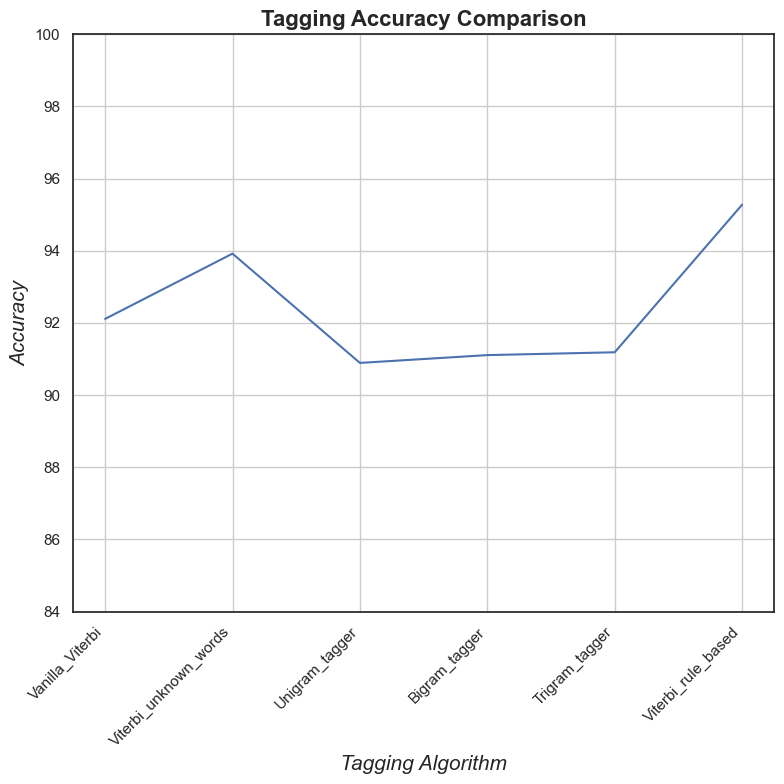

In [56]:
sns.set(style='white')
plt.figure(figsize=(8,8), dpi=100)
ax = sns.lineplot(data = accuracy_metrics_df)
ax.get_legend().remove()
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Tagging Accuracy Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Tagging Algorithm', fontsize= 15, fontstyle='oblique')
plt.ylabel('Accuracy', fontsize= 15, fontstyle='oblique')
plt.ylim(84,100)
plt.grid(True)
plt.tight_layout()
plt.show()

In [41]:
sample_test_sentences = ["Android is a mobile operating system developed by Google.",
"Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.",
"Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
"Twitter is an online news and social networking service on which users post and interact with messages known as tweets.",
"Before entering politics, Donald Trump was a domineering businessman and a television personality.",
"The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.",
"This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.",
"Show me the cheapest round trips from Dallas to Atlanta",
"I would like to see flights from Denver to Philadelphia.",
"Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.",
"NASA invited social media users to experience the launch of ICESAT-2 Satellite."]

In [42]:
sample_test_tokenized_sents = [word_tokenize(sent) for sent in sample_test_sentences]
sample_test_corpus_pos_tags = nltk.pos_tag_sents(sample_test_tokenized_sents, tagset = 'universal')
sample_test_corpus_pos_tags

[[('Android', 'NOUN'),
  ('is', 'VERB'),
  ('a', 'DET'),
  ('mobile', 'ADJ'),
  ('operating', 'NOUN'),
  ('system', 'NOUN'),
  ('developed', 'VERB'),
  ('by', 'ADP'),
  ('Google', 'NOUN'),
  ('.', '.')],
 [('Android', 'NOUN'),
  ('has', 'VERB'),
  ('been', 'VERB'),
  ('the', 'DET'),
  ('best-selling', 'ADJ'),
  ('OS', 'NOUN'),
  ('worldwide', 'NOUN'),
  ('on', 'ADP'),
  ('smartphones', 'NOUN'),
  ('since', 'ADP'),
  ('2011', 'NUM'),
  ('and', 'CONJ'),
  ('on', 'ADP'),
  ('tablets', 'NOUN'),
  ('since', 'ADP'),
  ('2013', 'NUM'),
  ('.', '.')],
 [('Google', 'NOUN'),
  ('and', 'CONJ'),
  ('Twitter', 'NOUN'),
  ('made', 'VERB'),
  ('a', 'DET'),
  ('deal', 'NOUN'),
  ('in', 'ADP'),
  ('2015', 'NUM'),
  ('that', 'DET'),
  ('gave', 'VERB'),
  ('Google', 'NOUN'),
  ('access', 'NOUN'),
  ('to', 'PRT'),
  ('Twitter', 'NOUN'),
  ("'s", 'PRT'),
  ('firehose', 'NOUN'),
  ('.', '.')],
 [('Twitter', 'NOUN'),
  ('is', 'VERB'),
  ('an', 'DET'),
  ('online', 'ADJ'),
  ('news', 'NOUN'),
  ('and', 'CONJ'

In [43]:
# list of untagged words from the sample test data provided
sample_test_tagged_words = [tup[0] for sent in sample_test_corpus_pos_tags for tup in sent]

# list of tagged words
sample_test_test_run_base = [tup for sent in sample_test_corpus_pos_tags for tup in sent]

sample_test_tagged_words

['Android',
 'is',
 'a',
 'mobile',
 'operating',
 'system',
 'developed',
 'by',
 'Google',
 '.',
 'Android',
 'has',
 'been',
 'the',
 'best-selling',
 'OS',
 'worldwide',
 'on',
 'smartphones',
 'since',
 '2011',
 'and',
 'on',
 'tablets',
 'since',
 '2013',
 '.',
 'Google',
 'and',
 'Twitter',
 'made',
 'a',
 'deal',
 'in',
 '2015',
 'that',
 'gave',
 'Google',
 'access',
 'to',
 'Twitter',
 "'s",
 'firehose',
 '.',
 'Twitter',
 'is',
 'an',
 'online',
 'news',
 'and',
 'social',
 'networking',
 'service',
 'on',
 'which',
 'users',
 'post',
 'and',
 'interact',
 'with',
 'messages',
 'known',
 'as',
 'tweets',
 '.',
 'Before',
 'entering',
 'politics',
 ',',
 'Donald',
 'Trump',
 'was',
 'a',
 'domineering',
 'businessman',
 'and',
 'a',
 'television',
 'personality',
 '.',
 'The',
 '2018',
 'FIFA',
 'World',
 'Cup',
 'is',
 'the',
 '21st',
 'FIFA',
 'World',
 'Cup',
 ',',
 'an',
 'international',
 'football',
 'tournament',
 'contested',
 'once',
 'every',
 'four',
 'years',
 '.'

In [44]:
#1. Testing the accuracy of Vanilla Viterbi on sample test data -

# tagging the test sentences
sample_test_tagged_seq = Vanilla_Viterbi(sample_test_tagged_words)

# Let's check the accuracy of the vanilla viterbi algorithm
sample_test_check = [i for i, j in zip(sample_test_tagged_seq, sample_test_test_run_base) if i == j]

vanilla_viterbi_accuracy_on_sample_test_data = len(sample_test_check)/len(sample_test_tagged_seq)

print("The accuracy of the Vanilla Viterbi Algorithm on the sample test data is -", vanilla_viterbi_accuracy_on_sample_test_data)

The accuracy of the Vanilla Viterbi Algorithm on the sample test data is - 0.7679558011049724


In [45]:
#2. Testing the accuracy of Vanilla_Viterbi_for_Unknown_Words on sample test data -

# tagging the test sentences
sample_test_unknown_word_tagged_seq = Viterbi_unknown_words(sample_test_tagged_words)

# accuracy
sample_test_unknown_word_check = [i for i, j in zip(sample_test_unknown_word_tagged_seq, sample_test_test_run_base) if i == j]

sample_test_optimized_viterbi_accuracy = len(sample_test_unknown_word_check)/len(sample_test_unknown_word_tagged_seq)

print("The accuracy of the Vanilla_Viterbi_for_Unknown_Words on the sample test data is -", sample_test_optimized_viterbi_accuracy)

The accuracy of the Vanilla_Viterbi_for_Unknown_Words on the sample test data is - 0.856353591160221


In [46]:
#3. Testing the accuracy of Viterbi Rule based tagger on sample test data -

# tagging the test sentences
sample_test_Viterbi_rule_based_tagged_seq = Viterbi_rule_based(sample_test_tagged_words)

# accuracy
sample_test_Viterbi_rule_based_check = [i for i, j in zip(sample_test_Viterbi_rule_based_tagged_seq, sample_test_test_run_base) if i == j]

sample_test_Viterbi_rule_based_accuracy = len(sample_test_Viterbi_rule_based_check)/len(sample_test_Viterbi_rule_based_tagged_seq)

print("The accuracy of the Viterbi_rule_based on the sample test data is -", sample_test_Viterbi_rule_based_accuracy)

The accuracy of the Viterbi_rule_based on the sample test data is - 0.9226519337016574


<b>Observation on sample test data:</b>

The default Vanilla viterbi algorithm(without any kind of modification)achieved an accuracy of about 76%, Modified one for unknown words achieved approx 85 percent & Rules based achieved approx 92% which is great when compare to other other two and it minimize the loss as well in terms of accuracy.

<b>Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm</b>


In [47]:

acccuracy_on_sample_test_data = [['Vanilla Viterbi', vanilla_viterbi_accuracy_on_sample_test_data*100], 
                  ['Optimized Vanilla Viterbi', sample_test_optimized_viterbi_accuracy*100], 
                  ['Viterbi_rule_based', sample_test_Viterbi_rule_based_accuracy*100]]

sample_test_data_acccuracy_df = pd.DataFrame(acccuracy_on_sample_test_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

sample_test_data_acccuracy_df.set_index('Tagging_Algorithm', drop = True, inplace = True)

sample_test_data_acccuracy_df

,Tagging_Accuracy
Tagging_Algorithm,
Vanilla Viterbi,76.795580
Optimized Vanilla Viterbi,85.635359
Viterbi_rule_based,92.265193


<AxesSubplot:xlabel='Tagging_Algorithm'>

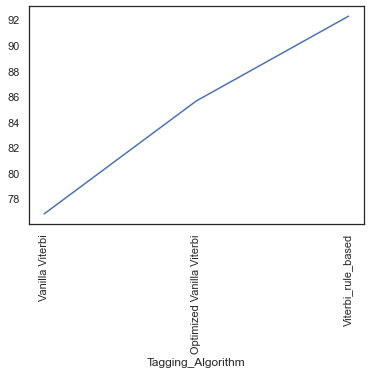

In [48]:
sample_test_data_acccuracy_df.plot.line(rot = 90, legend = False)

### List down cases which were incorrectly tagged by original POS tagger and got corrected by modifications

- In this task , we have considered some sample sentences as given to us and tried to correctly identify the incorrectly tagged POS Tags of Vanilla Viterbi using Modified Vanilla Viterbi

- Below 3 such cases have been listed along with the observation of correctly identified POS tags.

In [49]:
sample_test_sentences = ["Android is a mobile operating system developed by Google.",
"Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.",
"Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
"Twitter is an online news and social networking service on which users post and interact with messages known as tweets.",
"Before entering politics, Donald Trump was a domineering businessman and a television personality.",
"The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.",
"This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.",
"Show me the cheapest round trips from Dallas to Atlanta",
"I would like to see flights from Denver to Philadelphia.",
"Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.",
"NASA invited social media users to experience the launch of ICESAT-2 Satellite."]

We have considered few sentences from the above sampe sentences which were incorrectly tagged POS words using Vanilla Viterbi & correctly tagged after applying the modified Viterbi_rule_based tagged in our case.

In [50]:
#Case 1 :
test_sentence_2 = 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'

In [51]:
words_test_sentence_2 = nltk.word_tokenize(test_sentence_2)

# pos tags with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi = Vanilla_Viterbi(words_test_sentence_2)
print("Tagging sequence with Vanilla_Viterbi -\n\n", pos_tagged_sequence_with_vanilla_viterbi)

print('\n')
print('-'*120)

# pos tags with Viterbi_rule_based_tagger
pos_tagged_sequence_with_viterbi_rule_based = Viterbi_rule_based(words_test_sentence_2)
print("Tagging sequence with Viterbi_rule_based -\n\n", pos_tagged_sequence_with_viterbi_rule_based)

Tagging sequence with Vanilla_Viterbi -

 [('Android', 'VERB'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'VERB'), ('worldwide', 'VERB'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'VERB'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'VERB'), ('.', '.')]


------------------------------------------------------------------------------------------------------------------------
Tagging sequence with Viterbi_rule_based -

 [('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]


In [52]:
#<b>Case 2:</b>
test_sentence_3 = "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose."

In [53]:
words_test_sentence_3 = nltk.word_tokenize(test_sentence_3)

# pos tags with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi = Vanilla_Viterbi(words_test_sentence_3)
print("Tagging sequence with Vanilla_Viterbi -\n\n", pos_tagged_sequence_with_vanilla_viterbi)

print('\n')
print('-'*100)

# pos tags with Viterbi_rule_based tagger
pos_tagged_sequence_with_Viterbi_rule_based = Viterbi_rule_based(words_test_sentence_3)
print("Tagging sequence with viterbi_rule_based -\n\n", pos_tagged_sequence_with_Viterbi_rule_based)

Tagging sequence with Vanilla_Viterbi -

 [('Google', 'VERB'), ('and', 'CONJ'), ('Twitter', 'VERB'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'VERB'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'VERB'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'VERB'), ("'s", 'PRT'), ('firehose', 'VERB'), ('.', '.')]


----------------------------------------------------------------------------------------------------
Tagging sequence with viterbi_rule_based -

 [('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')]


In [54]:
#Case 3:
test_sentence_6 = "The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years."

In [55]:
words_test_sentence_6 = nltk.word_tokenize(test_sentence_6)

# pos tags with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi = Vanilla_Viterbi(words_test_sentence_6)
print("Tagging sequence with Vanilla_Viterbi -\n\n", pos_tagged_sequence_with_vanilla_viterbi)

print('\n')
print('-'*120)

# pos tags with viterbi_rule_based_tagger
pos_tagged_sequence_with_viterbi_rule_based = Viterbi_rule_based(words_test_sentence_6)
print("Tagging sequence with viterbi_rule_based_tagger -\n\n", pos_tagged_sequence_with_viterbi_rule_based)

Tagging sequence with Vanilla_Viterbi -

 [('The', 'DET'), ('2018', 'VERB'), ('FIFA', 'VERB'), ('World', 'NOUN'), ('Cup', 'VERB'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'VERB'), ('FIFA', 'VERB'), ('World', 'NOUN'), ('Cup', 'VERB'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'VERB'), ('contested', 'VERB'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN'), ('.', '.')]


------------------------------------------------------------------------------------------------------------------------
Tagging sequence with viterbi_rule_based_tagger -

 [('The', 'DET'), ('2018', 'NUM'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'NOUN'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'NOUN'), ('contested', 'VERB'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN'), 

### Cases that were tagged incorrectly by Vanilla Viterbi Algorithm but were corrected after applying the modifications

- In first case: '2011' incorrectly tagged as 'Verb' by Vanilla Viterbi & corrected by Viterbi_rule_based as Num.
- In second case: '2015' incorrectly tagged as 'Verb' by Vanilla Viterbi & corrected by Viterbi_rule_based as Num.
- In Third case: '2018' incorrectly tagged as 'Verb' by Vanilla Viterbi & corrected by Viterbi_rule_based as Num.

<b>Conclusion -</b>

We have seen that years were incorrectly tagged by the VANILLA VITERBI algorithm were corrected by the "Viterbi_rule_based".

1. Vanilla Viterbi: The vanilla viterbi gives us an accuracy of approx 92%,Hence it predicts more incorrect tags.

We have used 2 modification techniques of the Vanilla Viterbi method in order to imporove the accuracy.

2. Modified Vanilla Viterbi(for unknown words is used):

- This method showed an increase in the accuracy approx 94% but still had some incorrect classification.

The accuracy could be increased further and so we turned two a second modification.

3. Modified Vanilla Viterbi(The Viterbi_rule_based)
- This method gave an accuracy more than 95% and that's why we considered it as the winner in our case.

Accuracies of each method are as listed below

- Vanilla_Viterbi: 92.112510
- Viterbi_unknown_words: 93.922109
- Unigram_tagger: 90.892998
- Bigram_tagger: 91.109363
- Trigram_tagger: 91.188041
- Viterbi_rule_based: 95.279308
